# Pressure: An Observational Study 😨

Hypothesis: Higher pressure situations lessen the likelihood of field goal conversion.

In [81]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

## Load & Clean

In [82]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
17,MA-0700,1,43,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,NaN,855
34,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,856
52,MA-0700,1,24,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,857
64,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,858
95,MA-0700,1,48,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872984,RG-1500,1,27,2019,15,58,SF,Levi's Stadium,SF\r,0,...,0,5,0,1,0,0,0,1,0.984969,437
873062,RG-1500,1,42,2019,15,58,SF,Levi's Stadium,SF\r,0,...,0,5,0,1,1,0,0,2,0.987702,438
873087,RG-1500,1,38,2019,15,64,KC,Arrowhead Stadium,SF\r,0,...,0,7,1,1,0,0,0,1,0.989938,439


In [83]:
df.describe()

,good,dist,year,seasons,temperature,XP,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
count,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.0,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18710.000000,18803.000000
mean,0.844865,36.881242,2009.516992,7.913099,59.998032,0.0,29.927139,0.033771,0.352178,6.549593,0.487901,0.040845,0.125033,0.445408,0.080413,1.400202,0.846149,255.230601
std,0.362043,10.070235,5.643918,5.162924,15.656103,0.0,5.250091,0.180645,0.477662,5.986469,0.499867,0.197935,0.330765,0.497024,0.271938,1.024004,0.123667,209.053136
min,0.000000,18.000000,2000.000000,1.000000,-6.000000,0.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,28.000000,2005.000000,4.000000,50.000000,0.0,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.773014,94.000000
50%,1.000000,37.000000,2010.000000,7.000000,62.000000,0.0,29.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.866512,201.000000
75%,1.000000,45.000000,2014.000000,11.000000,70.000000,0.0,33.000000,0.000000,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.948108,362.000000
max,1.000000,76.000000,2019.000000,26.000000,109.000000,0.0,47.000000,1.000000,1.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1033.000000


## Explore

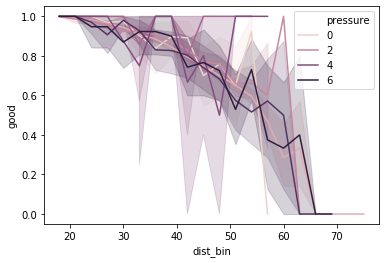

In [84]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='pressure', data=df_)

In [85]:
df = df[(df['dist']>=40)]
df.dropna(inplace=True)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
34,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,856
64,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,858
95,MA-0700,1,48,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,859
583,JH-0500,0,48,2000,4,77,GB,Lambeau Field,NYJ,0,...,1,5,1,0,0,0,0,1,0.550000,182
595,RL-1300,1,42,2000,4,77,GB,Lambeau Field,GB\r,0,...,1,5,0,0,0,0,0,1,1.000000,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872644,JM-7000,1,45,2019,5,23,GB,Lambeau Field,SEA,0,...,1,8,1,1,0,1,0,1,0.968405,142
872667,JM-7000,0,50,2019,5,23,GB,Lambeau Field,SEA,0,...,1,8,1,1,0,1,0,1,0.974150,143
872956,RG-1500,1,54,2019,15,58,SF,Levi's Stadium,SF\r,0,...,0,5,0,1,0,0,0,1,0.981628,436


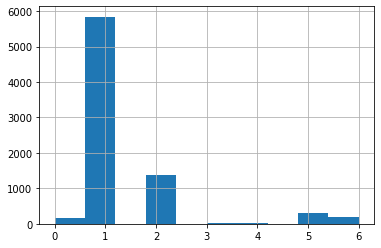

In [86]:
df['pressure'].hist()

In [87]:
df['pressure'].value_counts()

1    5843
2    1376
5     295
6     200
0     160
3      15
4      15
Name: pressure, dtype: int64

The distribution is very skewed. It may be necessary to collapse some of the categories. \[0,1\],\[2,3,4\],\[5,6\] (i.e. low, medium, high pressure)

In [88]:
df['pressure'] = df['pressure'].map({0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2})

In [89]:
df_low = df[df['pressure']==0]
df_med = df[df['pressure']==1]
df_high = df[df['pressure']==2]

In [90]:
df['pressure'].value_counts()

0    6003
1    1406
2     495
Name: pressure, dtype: int64

## Pair

In [91]:
def get_mask(data, row, pressure, ddist=4, dwind=7, dtemp=10, dyear=1, dkicks=100, dseas=2, dage=2):
    mask = (data['iced']==row['iced']) &\
           (abs(data['kicks']-row['kicks'])<=dkicks) &\
           (abs(data['seasons']-row['seasons'])<=dseas) &\
           (abs(data['age']-row['age'])<=dseas) &\
           (abs(data['dist']-row['dist'])<=ddist) &\
           (abs(data['wind']-row['wind'])<=dwind) &\
           (abs(data['temperature']-row['temperature'])<=dtemp) &\
           (abs(data['year']-row['year'])<=dyear) &\
           (data['postseason']==row['postseason']) &\
           (data['turf']==row['turf']) &\
           (data['altitude']==row['altitude']) &\
           (data['away_game']==row['away_game']) &\
           (data['precipitation']==row['precipitation']) &\
           (data['pressure']==level) # want rows at this level
    return mask

def get_diff(df, row):
    for i in row.index:
        if not isinstance(row[i],str):
            df[i+'_d'] = df[i].sub(row[i]).abs()
    return df

In [92]:
pressures = {}
for level, df_pres in zip((0,1),(df_low,df_med)):
    pres = {}
    for index, row in df_high.iterrows():
        mask = get_mask(df_pres, row, level)
        df_choices = get_diff(df_pres[mask],row).sort_values(['dist_d','year_d','kicks_d','wind_d','temperature_d','seasons_d','age_d'])
        for i, choice in df_choices.iterrows():
            if i not in pres:
                choice['match_pid'] = index
                pres[i] = choice
                break
    print(len(df_high)-len(pres), 'are missing matches.')
    pressures[level] = pd.DataFrame.from_dict(pres, orient='index').sort_values(['dist_d','year_d','seasons_d'])

229 are missing matches.
344 are missing matches.


In [93]:
low_matches = set(pressures[0]['match_pid'])
med_matches = set(pressures[1]['match_pid'])
both_matched = low_matches.intersection(med_matches)
print(len(both_matched), 'crossover.')
df_high = df_high.loc[both_matched,:]
df_med = pressures[0][pressures[0]['match_pid'].isin(both_matched)]
df_low = pressures[1][pressures[1]['match_pid'].isin(both_matched)]
df_high

120 crossover.


,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
276481,JE-0200,1,49,2006,14,70,DEN,Invesco Field at Mile High,DEN,0,...,0,4,0,0,0,0,0,2,0.776685,567
109570,SC-0700,1,40,2002,13,72,SD,Qualcomm Stadium,SD\r,0,...,0,9,0,0,0,0,0,2,0.797583,545
162308,JK-0200,1,49,2003,13,63,ARI,Sun Devil Stadium,CAR,0,...,0,4,1,0,0,0,0,2,0.520447,514
871945,WL-0300,1,49,2019,4,66,NO,Mercedes-Benz Superdome,NO\r,0,...,0,0,0,1,1,1,0,2,0.809097,144
115213,JE-0200,0,53,2002,10,64,SD,Qualcomm Stadium,DEN,0,...,1,7,1,0,0,0,0,2,0.773640,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660975,JM-7000,0,48,2015,1,57,IND,Lucas Oil Stadium,JAC,0,...,0,0,1,0,0,1,0,2,0.729035,9
682485,JB-7100,0,48,2015,13,51,NYG,MetLife Stadium,NYG,0,...,0,8,0,0,0,1,0,2,0.999922,371
618486,DB-0200,1,49,2014,4,70,DAL,AT&T Stadium,DAL,0,...,0,0,0,0,0,1,0,2,0.817520,107


## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free.

In [94]:
from scipy.stats import beta
p_hat = df[df['dist']>=40]['good'].mean()
# beta_ = 2
# alpha_ = int(round(p_hat*beta_/(1-p_hat)))
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 5


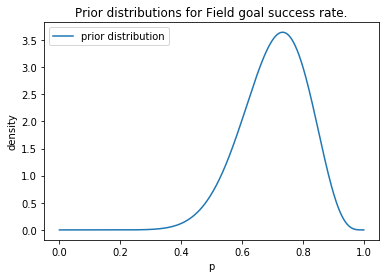

In [95]:
x = np.linspace(0,1,500)
plt.plot(x, beta(alpha_, beta_).pdf(x), label='prior distribution')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Prior distributions for Field goal success rate.')
plt.legend()
plt.show()

In [96]:
from scipy.stats import beta
posterior_low = beta(alpha_ + df_low['good'].sum(), beta_ + len(df_low) - df_low['good'].sum())
posterior_med = beta(alpha_ + df_med['good'].sum(), beta_ + len(df_med) - df_med['good'].sum())
posterior_high = beta(alpha_ + df_high['good'].sum(), beta_ + len(df_high) - df_high['good'].sum())
samples = 20000
samples_posterior_low = posterior_low.rvs(samples)
samples_posterior_med = posterior_med.rvs(samples)
samples_posterior_high = posterior_high.rvs(samples)

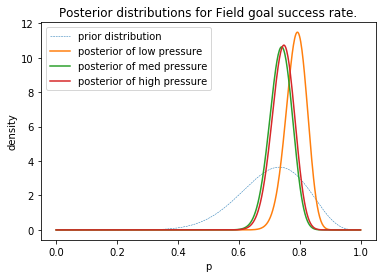

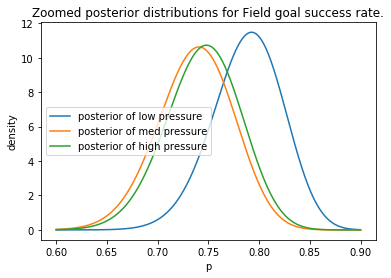

In [97]:
x = np.linspace(0,1,500)
plt.plot(x, beta(alpha_, beta_).pdf(x), label='prior distribution', linestyle='dashed', linewidth=0.5)
plt.plot(x, posterior_low.pdf(x), label='posterior of low pressure')
plt.plot(x, posterior_med.pdf(x), label='posterior of med pressure')
plt.plot(x, posterior_high.pdf(x), label='posterior of high pressure')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distributions for Field goal success rate.')
plt.legend()
plt.show()

x = np.linspace(0.6,0.9,500)
plt.plot(x, posterior_low.pdf(x), label='posterior of low pressure')
plt.plot(x, posterior_med.pdf(x), label='posterior of med pressure')
plt.plot(x, posterior_high.pdf(x), label='posterior of high pressure')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Zoomed posterior distributions for Field goal success rate.')
plt.legend()
plt.show()

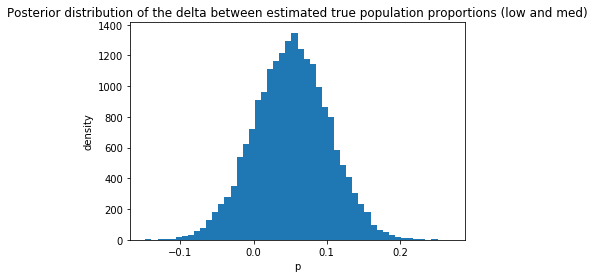

84 % likely that low pressure has a higher true population proportion of converted field goals than medium pressure.
0.05 is the median difference, with credible interval of (-0.05,0.15).


In [98]:
posterior_diff = samples_posterior_low - samples_posterior_med

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and med)')
plt.show()
print(int((samples_posterior_low>samples_posterior_med).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than medium pressure.')

from scipy.stats import bayes_mvs
center, _, std = bayes_mvs(posterior_diff, alpha=0.95)
print(f'{round(center.statistic,2)} is the median difference, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

80 % likely relative lift greater than 1%.
0.07 is the median relative lift, with credible interval of (-0.07,0.22).


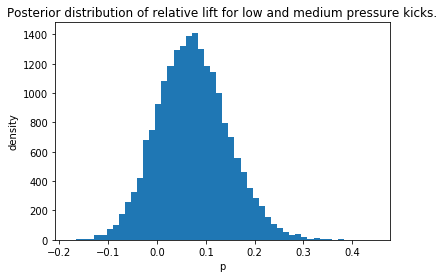

In [99]:
posterior_relative = (samples_posterior_low-samples_posterior_med)/samples_posterior_med
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and medium pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift greater than 1%.')

center, _, std = bayes_mvs(posterior_relative, alpha=0.95)
print(f'{round(center.statistic,2)} is the median relative lift, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

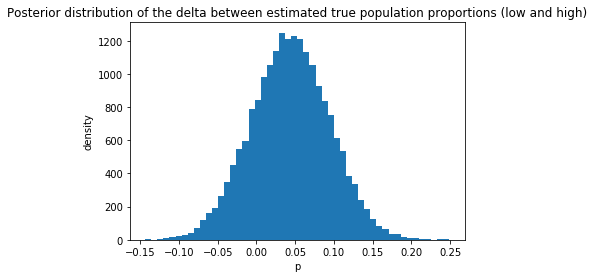

80 % likely that low pressure has a higher true population proportion of converted field goals than high pressure.
0.04 is the median difference, with credible interval of (-0.06,0.14).


In [100]:
posterior_diff = samples_posterior_low - samples_posterior_high

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and high)')
plt.show()
print(int((samples_posterior_low>samples_posterior_high).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than high pressure.')

from scipy.stats import bayes_mvs
center, _, std = bayes_mvs(posterior_diff, alpha=0.95)
print(f'{round(center.statistic,2)} is the median difference, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

76 % likely relative lift greater than 1%.
0.06 is the median relative lift, with credible interval of (-0.08,0.2).


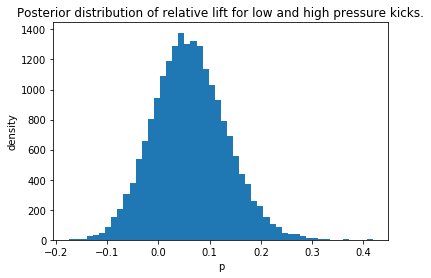

In [101]:
posterior_relative = (samples_posterior_low-samples_posterior_high)/samples_posterior_high
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and high pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift greater than 1%.')

center, _, std = bayes_mvs(posterior_relative, alpha=0.95)
print(f'{round(center.statistic,2)} is the median relative lift, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

## Conclusions

* There is no noticeable difference in estimated true population proportion for high and medium kicks.
* Low pressure kicks likely have a slightly higher true population proportion, however the relative increase is only around 5-7% above that of medium and high pressure kicks.